# Effect of House Characteristics on Their Prices 
## by Lubomir Straka

>**Before you start**: You must have the README.md file ready that include a summary of main findings that reflects on the steps taken during the data exploration (Part I notebook). The README.md file should also describes the key insights that will be conveyed by the explanatory slide deck (Part II  outcome)



## Investigation Overview


> Describe the overall goals of your presentation here. Add a summary of key insights at the start of the notebook, just as you added in the README.md. This will help your notebook to stay aligned to the key insights you want to include in your slide deck.

> **Rubric Tip**: The key insights in the slideshow must match those documented in the README.md summary. 

In this investigation, I wanted to look at the key characteristics of houses that could be used to predict their prices. The main focus was on three aspects: above grade living area representing space characteristics, overall quality of house's material and finish representing physical characteristics, and neighborhood cluster representing location characteristics.

## Dataset Overview

> Provide a brief overview of the dataset to be presented here.

The data consists of information regarding 1460 houses in Ames, Iowa, including their sale price, physical characteristics, space properties and location within the city as provided by [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data). The data set contains 1460 observations and a large number of explanatory variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous) involved in assessing home values. These 79 explanatory variables plus one response variable (sale price) describe almost every aspect of residential homes in Ames, Iowa.

In addition to some basic data type encoding, missing value imputing and cleaning, four outliers were removed from the analysis due to unusual sale conditions.

In [1]:
# Import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# Load the Ames Housing dataset
path = 'https://raw.githubusercontent.com/lustraka/Data_Analysis_Workouts/main/Communicate_Data_Findings/ames_train_data.csv'
ames = pd.read_csv(path, index_col='Id')
################
# Wrangle data #
################
# The numeric features are already encoded correctly (`float` for
# continuous, `int` for discrete), but the categoricals we'll need to
# do ourselves. Note in particular, that the `MSSubClass` feature is
# read as an `int` type, but is actually a (nominative) categorical.

# The categorical features nominative (unordered)
catn = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig",
        "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", 
        "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", 
        "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", 
        "SaleType", "SaleCondition"]


# The categorical features ordinal (ordered) 

# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

cato = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
cato = {key: ["None"] + value for key, value in
                  cato.items()}


def encode_dtypes(df):
    """Encode nominal and ordinal categorical variables."""

    global catn, cato

    # Nominal categories
    for name in catn:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in cato.items():
        df[name] = df[name].astype(pd.CategoricalDtype(levels,
                                                    ordered=True))
    return df

def impute_missing(df):
    """Impute zeros to numerical and None to categorical variables."""

    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

def clean_data(df):
    """Remedy typos and mistakes based on EDA."""

    global cato
    # YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)
    df.YearRemodAdd = np.where(df.YearRemodAdd < df.YearBuilt, df.YearBuilt, df.YearRemodAdd)
    assert len(df.loc[df.YearRemodAdd < df.YearBuilt]) == 0, 'Check YearRemodAdd - should be greater or equal then YearBuilt'
    
    # Check range of years
    yr_max = 2022
    # Some values of GarageYrBlt are corrupt. Fix them by replacing them with the YearBuilt
    df.GarageYrBlt = np.where(df.GarageYrBlt > yr_max, df.YearBuilt, df.GarageYrBlt)
    assert df.YearBuilt.max() < yr_max and df.YearBuilt.min() > 1800, 'Check YearBuilt min() and max()'
    assert df.YearRemodAdd.max() < yr_max and df.YearRemodAdd.min() > 1900, 'Check YearRemodAdd min() and max()'
    assert df.YrSold.max() < yr_max and df.YrSold.min() > 2000, 'Check YrSold min() and max()'
    assert df.GarageYrBlt.max() < yr_max and df.GarageYrBlt.min() >= 0, 'Check GarageYrBlt min() and max()'
    
    # Check values of ordinal catagorical variables
    for k in cato.keys():
      assert set(df[k].unique()).difference(df[k].cat.categories) == set(), f'Check values of {k}'
    
    # Check typos in nominal categorical variables
    df['Exterior2nd'] = df['Exterior2nd'].replace({'Brk Cmn':'BrkComm', 'CmentBd':'CemntBd', 'Wd Shng':'WdShing'})
    # Renew a data type after replacement
    df['Exterior2nd'] = df['Exterior2nd'].astype("category")
    if "None" not in df['Exterior2nd'].cat.categories:
        df['Exterior2nd'].cat.add_categories("None", inplace=True)

    return df

def label_encode(df):
    """Encode categorical variables using their dtype setting."""

    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X

# Pre-process data
ames = encode_dtypes(ames)
ames = impute_missing(ames)
ames = clean_data(ames)

# Add log transformed SalePrice to the dataset
ames['logSalePrice'] = ames.SalePrice.apply(np.log10)

## Distribution of House Prices

> Write a comment about your visualization here. The visualization should be in the next cell, as a sub-slide type. Make sure your visualizations are polished!

> **Rubric Tip**: Provide at least 3 **polished** visualizations to convey key insights. The total number of visualizations in the slideshow shoould be less than 50% of the number of visualizations in the exploratory analysis. For example, if the exploratory analysis (Part I) has 18 visualizations, the slideshow can have (3 - 8) visualizations. 


> **Rubric Tip**: Each visualization in the slideshow is associated with **descriptive comments** that accurately depict their purpose and your observation. 


> **Rubric Tip**: All plots in the slideshow are appropriate, meaning the plot type, encodings, and transformations are suitable to the underlying data. 

> **Rubric Tip**: All plots in the slideshow are polished, meaning all plots have a title, labeled x/y axes (with units), x/y ticks, and legends. 

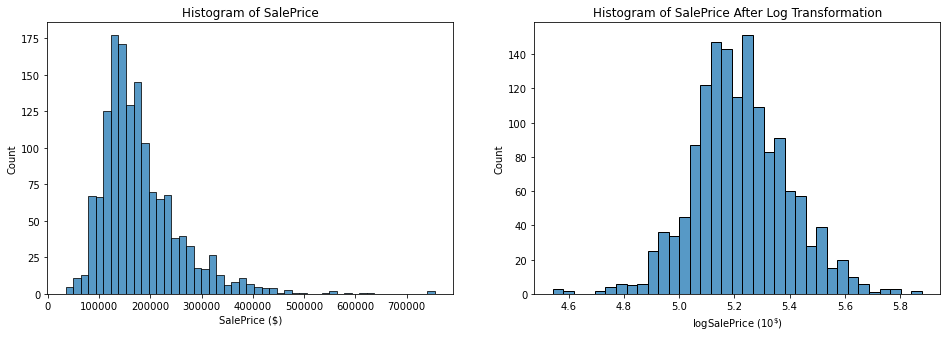

In [3]:
# Plot SalePrice with a standard and log scale
fig, axs = plt.subplots(1, 2, figsize=[16,5])
# LEFT plot
sns.histplot(data=ames, x='SalePrice', ax=axs[0])
axs[0].set_title('Histogram of SalePrice')
axs[0].set_xlabel('SalePrice ($)')
# RIGHT plot
sns.histplot(data=ames, x='logSalePrice', ax=axs[1])
axs[1].set_title('Histogram of SalePrice After Log Transformation')
axs[1].set_xlabel('logSalePrice ($10^\$$)')
plt.show()

## Distribution of Living Area

> You should have at least three visualizations in your presentation,
but feel free to add more if you'd like!

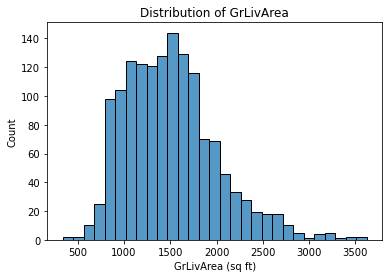

In [4]:
# Remove outliers
ames = ames.query('GrLivArea < 4000').copy()

# Plot a distribution of GrLivArea
sns.histplot(data=ames, x='GrLivArea')
plt.title('Distribution of GrLivArea')
plt.xlabel('GrLivArea (sq ft)')
plt.show()

## Sale Price vs Overall Quality



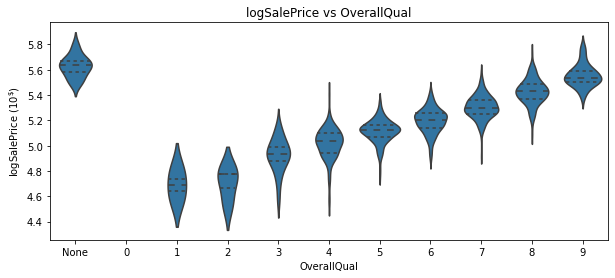

In [5]:
# Set the base color
base_color = sns.color_palette()[0]

# Show violin plot
plt.figure(figsize=(10,4))
sns.violinplot(data=ames, x='OverallQual', y='logSalePrice', color=base_color, inner='quartile')
plt.ylabel('logSalePrice ($10^\$$)')
plt.title('logSalePrice vs OverallQual')
plt.show()

## Sale Price vs Neighborhood

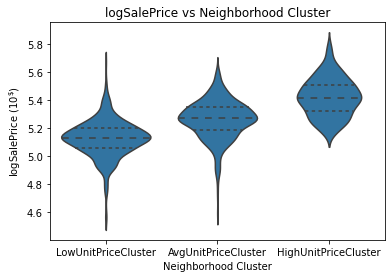

In [6]:
# Add a variable with total surface area
ames['TotalSF'] = ames['TotalBsmtSF'] + ames['1stFlrSF'] + ames['2ndFlrSF'] + ames['GarageArea']
# Calculate price per square feet
ames['SalePricePerSF'] = ames.SalePrice / ames.TotalSF

# Cluster neighborhoods into three clusters
ngb_mean_df = ames.groupby('Neighborhood')['SalePricePerSF'].mean().dropna()
bins = np.linspace(ngb_mean_df.min(), ngb_mean_df.max(), 4)
clusters = ['LowUnitPriceCluster', 'AvgUnitPriceCluster', 'HighUnitPriceCluster']
# Create a dict 'Neighborhood' : 'Cluster'
ngb_clusters = pd.cut(ngb_mean_df, bins=bins, labels=clusters, include_lowest=True).to_dict()

# Add new feature to the dataset
ames['NgbCluster'] = ames.Neighborhood.apply(lambda c: ngb_clusters.get(c, "")).astype(pd.CategoricalDtype(clusters, ordered=True))

# Plot the new feature
sns.violinplot(data=ames, x='NgbCluster', y='logSalePrice', color=base_color, inner='quartile')
plt.xlabel('Neighborhood Cluster')
plt.ylabel('logSalePrice ($10^\$$)')
plt.title('logSalePrice vs Neighborhood Cluster')
plt.show()

## Sale Price vs Living Area and Location

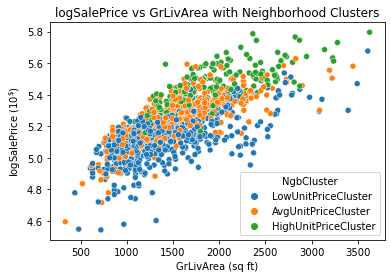

In [7]:
# Combine space and location variables
sns.scatterplot(data=ames, x='GrLivArea', y='logSalePrice', hue='NgbCluster')
plt.title('logSalePrice vs GrLivArea with Neighborhood Clusters')
plt.xlabel('GrLivArea (sq ft)')
plt.ylabel('logSalePrice ($10^\$$)')
plt.show()

## Sale Price vs Overall Quality by Location

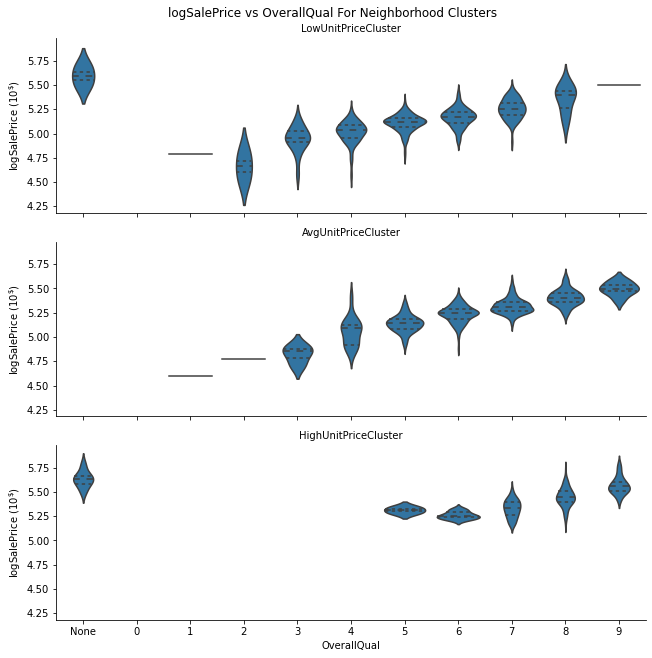

In [8]:
# Combine building and location variables
g = sns.FacetGrid(data=ames, row='NgbCluster', aspect=3)
g.map(sns.violinplot, 'OverallQual', 'logSalePrice', inner='quartile')
g.set_titles('{row_name}')
g.set_ylabels('logSalePrice ($10^\$$)')
g.fig.suptitle('logSalePrice vs OverallQual For Neighborhood Clusters', y=1.01)
plt.show()

>**Generate Slideshow**: Once you're ready to generate your slideshow, use the `jupyter nbconvert` command to generate the HTML slide show. . From the terminal or command line, use the following expression.

In [9]:
# !jupyter nbconvert Part_II_slide_deck_ames.ipynb --to slides --post serve --no-input --no-prompt

> This should open a tab in your web browser where you can scroll through your presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent slide. Make sure you remove all of the quote-formatted guide notes like this one before you finish your presentation! At last, you can stop the Kernel. 